# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time

## Uploading data from file

In [2]:
DATA_PATH = "../../../data/4_best_predictions/"
FILE_PATTERN = "bit_fingerprint_predictions_{0}.csv"

In [3]:
valid = pd.read_csv(DATA_PATH + FILE_PATTERN.format('valid'))
test = pd.read_csv(DATA_PATH + FILE_PATTERN.format('test'))

In [4]:
compare_data = pd.DataFrame({'smiles': test.smiles, 'y_expected': test.logp, 'y_predicted': test.logp_pred})

In [5]:
X_valid_mol = [Chem.MolFromSmiles(x) for x in valid.smiles]
X_test_mol = [Chem.MolFromSmiles(x) for x in test.smiles]

In [6]:
y_test = test.logp
y_valid = valid.logp

## Getting the data to compare

In [7]:
compare_data.head()

,smiles,y_expected,y_predicted
0,Cc1ccccc1C(C)C,4.38,4.271274
1,Clc1nc(-c2ccccc2)nc2ccccc12,4.47,5.203018
2,Cc1ccc(O)c(C(=O)O)c1,2.78,1.591805
3,O=c1[nH]c(O)c(-c2ccccc2)[nH]1,0.46,0.024980
4,CN(C)CCN1c2ccccc2Sc2ccccc21,4.20,3.574062


In [8]:
compare_data.shape

(1894, 3)

In [9]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [10]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
79,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)O[K],0.65,5.077822,19.605604
1015,CCc1c(C(=O)O)c(=O)cnn1-c1ccc(Cl)cc1,-2.20,1.996477,17.610420
147,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,1.36,5.033193,13.492348
674,CC(C)(C)NC(=O)C1CCC2C3CCC4NC(=O)C=CC4(C)C3CCC12C,3.03,6.293756,10.652101
121,CCCCCCCCCCCCCCCC(=O)O,7.17,4.008034,9.998028


In [11]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
1677,COC(=O)c1cnc2n(c1=O)C(C)CCC2,0.16,0.159930,4.830562e-09
1534,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,2.42,2.420206,4.261877e-08
1079,NC(=O)c1cnc2n(c1=O)CCCC2,-0.38,-0.380800,6.396566e-07
420,Oc1ccc(O)n1-c1ccccc1Br,0.65,0.650861,7.406896e-07
1182,Clc1cc(Cl)c2oc3c(Cl)c(Cl)c(Cl)cc3c2c1,6.59,6.589064,8.762668e-07


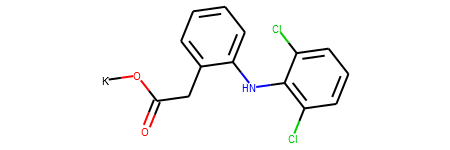

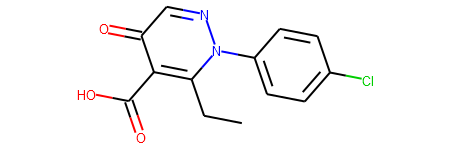

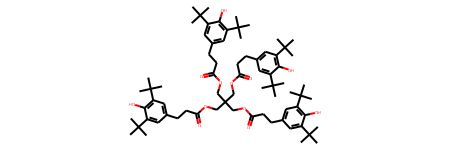

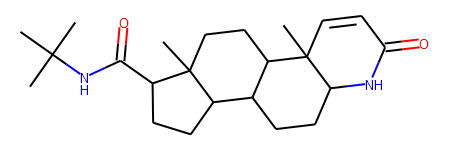

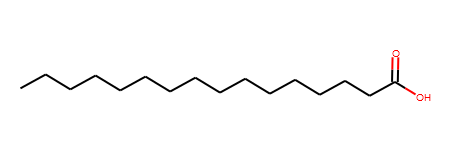

In [12]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

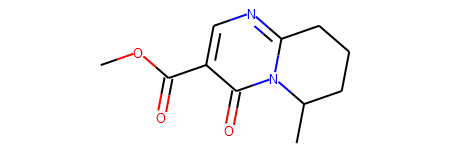

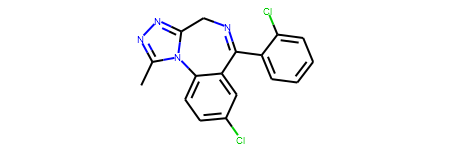

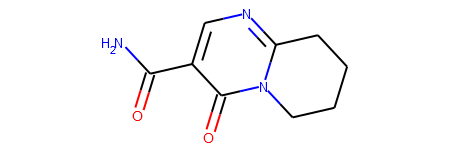

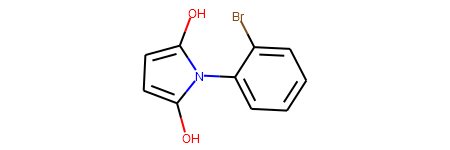

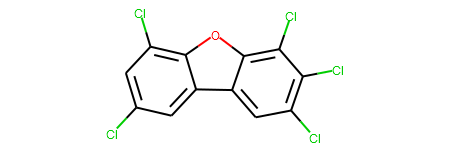

In [13]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [14]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings
- The count and percent of aromatic bonds
- The symmetry of molecules

In [15]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

## Analyzing the data features

In [16]:
compare_data_with_stats = create_statistics(compare_data)

In [17]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1677,COC(=O)c1cnc2n(c1=O)C(C)CCC2,0.16,0.159930,4.830562e-09,5,1,0,0.0,0,0.000000,17,6,35.294118,False
1534,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,2.42,2.420206,4.261877e-08,15,2,0,0.0,2,100.000000,26,17,65.384615,False
1079,NC(=O)c1cnc2n(c1=O)CCCC2,-0.38,-0.380800,6.396566e-07,26,3,0,0.0,1,33.333333,15,6,40.000000,False
420,Oc1ccc(O)n1-c1ccccc1Br,0.65,0.650861,7.406896e-07,57,4,0,0.0,1,25.000000,15,11,73.333333,False
1182,Clc1cc(Cl)c2oc3c(Cl)c(Cl)c(Cl)cc3c2c1,6.59,6.589064,8.762668e-07,8,1,0,0.0,0,0.000000,20,15,75.000000,False


#### Splitting data into 3 parts

In [18]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [19]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,1.778288,1.778849,1.288172e-02,16.356577,1.683043,0.879556,5.579299,0.863708,50.781828,16.217116,6.960380,43.995403
std,1.633597,1.629728,1.208160e-02,6.385098,1.003651,1.366752,8.695894,0.760408,42.086203,7.063797,4.081707,23.058914
min,-3.640000,-3.622343,4.830562e-09,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.665000,0.645564,2.210470e-03,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000,6.000000,31.578947
50%,1.690000,1.718518,8.920644e-03,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,15.000000,6.000000,46.153846
75%,2.705000,2.724022,2.212398e-02,19.000000,2.000000,1.000000,9.090909,1.000000,100.000000,19.000000,10.000000,60.000000
max,8.050000,7.961444,4.319726e-02,57.000000,6.000000,9.000000,60.000000,5.000000,100.000000,60.000000,27.000000,100.000000


In [20]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,1.965166,1.945996,0.123487,16.679873,1.646593,0.958796,6.406167,0.843106,51.329900,16.988906,7.481775,45.113470
std,1.696107,1.685439,0.057411,7.716950,1.132626,1.430356,9.904532,0.769939,43.029792,7.323470,4.311215,23.132395
min,-2.190000,-1.911653,0.043357,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.800000,0.745417,0.074327,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,31.578947
50%,1.780000,1.769286,0.110632,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,2.960000,2.976560,0.167256,20.000000,2.000000,1.000000,9.307359,1.000000,100.000000,20.000000,11.000000,60.000000
max,8.010000,8.286664,0.249056,85.000000,8.000000,9.000000,80.000000,6.000000,100.000000,65.000000,26.000000,100.000000


In [21]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,2.368838,2.310463,1.199086,16.398734,1.705696,0.780063,5.074059,0.911392,55.245253,18.245253,7.226266,40.377282
std,2.038885,1.800441,1.705490,6.939348,1.150525,1.214303,8.461893,0.781155,42.952188,8.807412,5.084179,26.681597
min,-3.890000,-3.187424,0.249153,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.990000,1.129817,0.384252,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.000000,5.000000,24.000000
50%,2.315000,2.162903,0.661232,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000,17.000000,6.000000,42.857143
75%,3.642500,3.384488,1.367347,19.000000,2.000000,1.000000,7.692308,1.000000,100.000000,22.000000,12.000000,58.823529
max,9.050000,8.522834,19.605604,58.000000,8.000000,9.000000,71.428571,5.000000,100.000000,88.000000,27.000000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [22]:
best = data[0].reset_index().drop(columns=['index'])

In [23]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,COC(=O)c1cnc2n(c1=O)C(C)CCC2,0.16,0.159930,4.830562e-09,5,1,0,0.0,0,0.000000,17,6,35.294118,False
1,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,2.42,2.420206,4.261877e-08,15,2,0,0.0,2,100.000000,26,17,65.384615,False
2,NC(=O)c1cnc2n(c1=O)CCCC2,-0.38,-0.380800,6.396566e-07,26,3,0,0.0,1,33.333333,15,6,40.000000,False
3,Oc1ccc(O)n1-c1ccccc1Br,0.65,0.650861,7.406896e-07,57,4,0,0.0,1,25.000000,15,11,73.333333,False
4,Clc1cc(Cl)c2oc3c(Cl)c(Cl)c(Cl)cc3c2c1,6.59,6.589064,8.762668e-07,8,1,0,0.0,0,0.000000,20,15,75.000000,False


In [24]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=10))

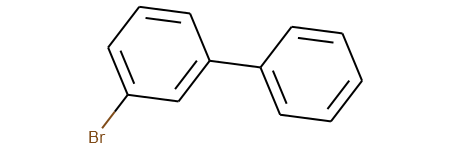

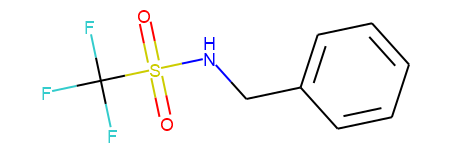

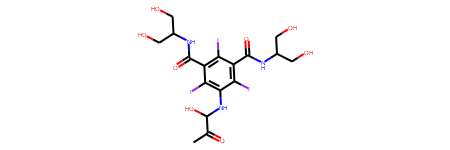

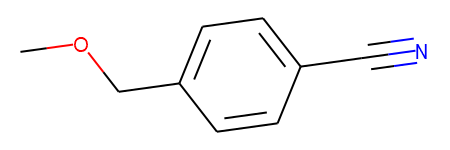

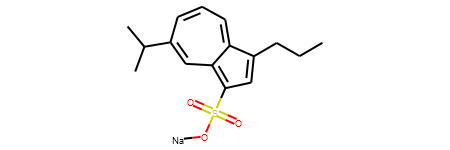

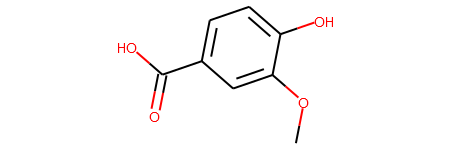

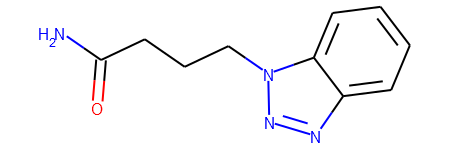

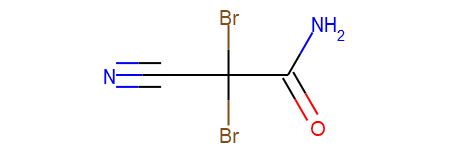

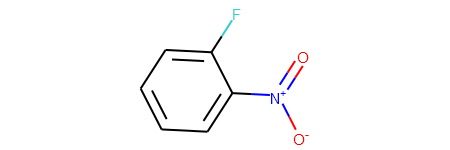

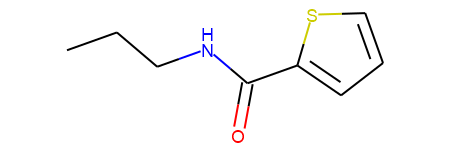

In [25]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [26]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [27]:
middle = data[1].reset_index().drop(columns=['index'])

In [28]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,CCN1CC(C(O)C(CC2CCCCC2)NC(=O)C(Cc2cc[nH]n2)NC(...,2.49,2.281778,0.043357,14,2,0,0.000000,1,50.0,52,11,21.153846,False
1,N#Cc1ccc(OCC(=O)O)cc1,0.93,0.720253,0.043994,13,1,1,7.692308,1,100.0,13,6,46.153846,False
2,N#Cc1ccc(C#N)cc1,0.93,1.140012,0.044105,22,2,3,13.636364,1,50.0,10,6,60.000000,True
3,Cc1cnc2n(c1=O)CCCC2,0.12,0.330247,0.044204,9,1,0,0.000000,0,0.0,13,6,46.153846,False
4,COC(=O)C(C#N)=NNc1cc(Cl)cc(Cl)c1,4.50,4.710589,0.044348,14,2,2,14.285714,1,50.0,17,6,35.294118,False


In [29]:
middle.shape

(631, 14)

In [30]:
indices = pd.Series(np.random.randint(631, size=10))

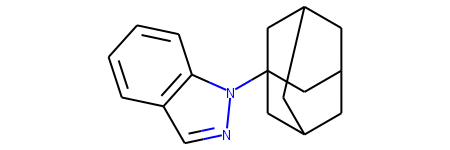

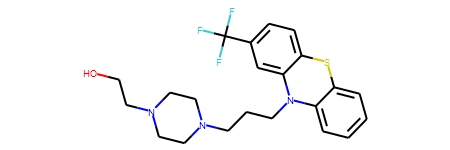

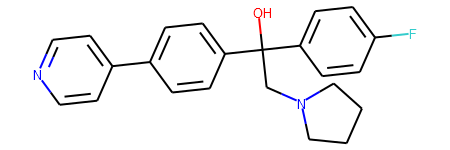

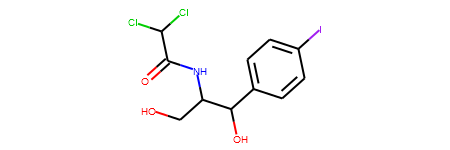

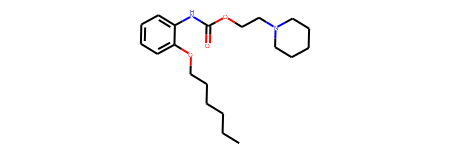

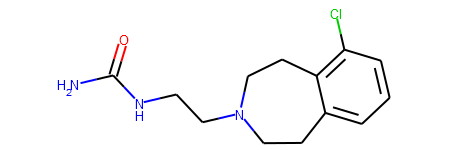

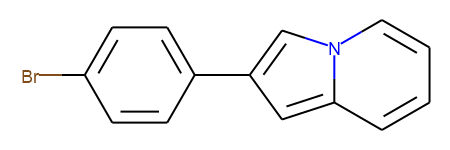

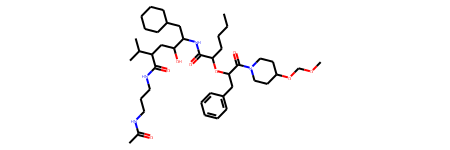

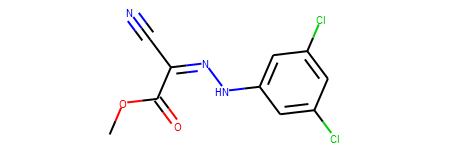

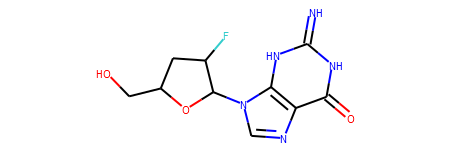

In [31]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [32]:
worst = data[2].reset_index().drop(columns=['index'])

In [33]:
indices = pd.Series(np.random.randint(631, size=10))

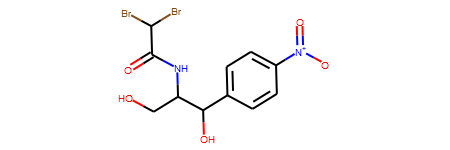

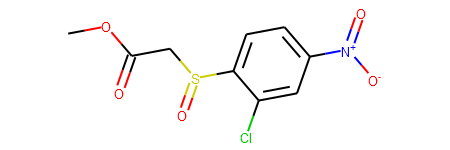

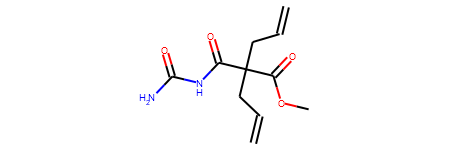

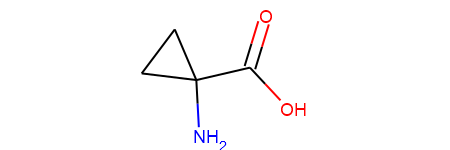

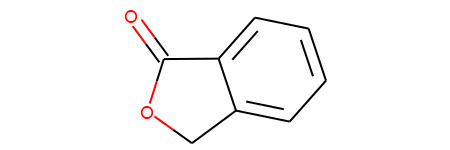

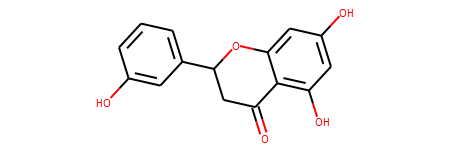

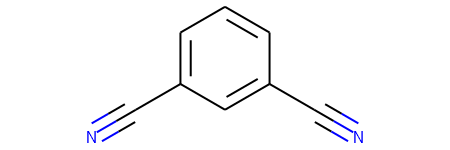

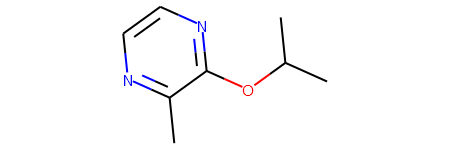

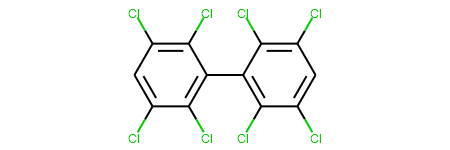

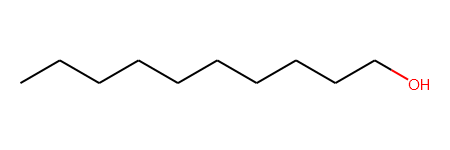

In [34]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [35]:
n_values = 200

In [36]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [37]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [38]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1677,COC(=O)c1cnc2n(c1=O)C(C)CCC2,0.16,0.159930,4.830562e-09,5,1,0,0.0,0,0.000000,17,6,35.294118,False
1534,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,2.42,2.420206,4.261877e-08,15,2,0,0.0,2,100.000000,26,17,65.384615,False
1079,NC(=O)c1cnc2n(c1=O)CCCC2,-0.38,-0.380800,6.396566e-07,26,3,0,0.0,1,33.333333,15,6,40.000000,False
420,Oc1ccc(O)n1-c1ccccc1Br,0.65,0.650861,7.406896e-07,57,4,0,0.0,1,25.000000,15,11,73.333333,False
1182,Clc1cc(Cl)c2oc3c(Cl)c(Cl)c(Cl)cc3c2c1,6.59,6.589064,8.762668e-07,8,1,0,0.0,0,0.000000,20,15,75.000000,False


In [39]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
79,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)O[K],0.65,5.077822,19.605604,17,2,3,17.647059,2,100.0,21,12,57.142857,False
1015,CCc1c(C(=O)O)c(=O)cnn1-c1ccc(Cl)cc1,-2.20,1.996477,17.610420,24,2,4,16.666667,2,100.0,20,12,60.000000,False
147,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,1.36,5.033193,13.492348,13,1,0,0.000000,0,0.0,88,24,27.272727,True
674,CC(C)(C)NC(=O)C1CCC2C3CCC4NC(=O)C=CC4(C)C3CCC12C,3.03,6.293756,10.652101,11,0,1,9.090909,0,0.0,30,0,0.000000,False
121,CCCCCCCCCCCCCCCC(=O)O,7.17,4.008034,9.998028,34,1,3,8.823529,1,100.0,17,0,0.000000,False


In [40]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.757100,1.760876,1.085034e-03,15.930000,1.625000,0.920000,6.182602,0.820000,47.966667,16.045000,6.860000,43.355490
std,1.643984,1.646517,1.015027e-03,6.245006,0.948087,1.460915,10.083939,0.761907,42.415930,6.259303,3.986207,23.072234
min,-3.640000,-3.622343,4.830562e-09,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.640000,0.641065,1.916423e-04,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000,6.000000,31.578947
50%,1.685000,1.702126,7.222740e-04,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,15.000000,6.000000,45.993590
75%,2.735000,2.749822,1.798011e-03,19.000000,2.000000,1.000000,9.090909,1.000000,100.000000,20.000000,10.000000,60.000000
max,6.790000,6.821583,3.428445e-03,57.000000,5.000000,8.000000,60.000000,3.000000,100.000000,37.000000,23.000000,91.666667


In [41]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.859567,2.565962,2.669916,16.465000,1.670000,0.805000,5.369636,0.865000,52.483333,19.910000,7.895000,39.577981
std,2.370861,1.837567,2.437443,6.561558,1.027804,1.189136,8.941919,0.767935,42.886821,10.156163,5.974315,28.290980
min,-3.700000,-2.125511,1.076264,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.235000,1.431023,1.429476,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14.000000,5.000000,18.474265
50%,2.955000,2.462817,1.939678,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000,19.000000,6.000000,42.857143
75%,4.470000,3.449601,2.939435,20.000000,2.000000,1.000000,7.692308,1.000000,100.000000,24.000000,12.000000,58.126935
max,9.050000,8.522834,19.605604,49.000000,5.000000,7.000000,71.428571,4.000000,100.000000,88.000000,27.000000,100.000000


### Check atom_count influence

In [42]:
print(stats.ttest_ind(best_n_vals.atom_count, worst_n_vals.atom_count))

Ttest_indResult(statistic=-0.8352539067863282, pvalue=0.40407587351928265)


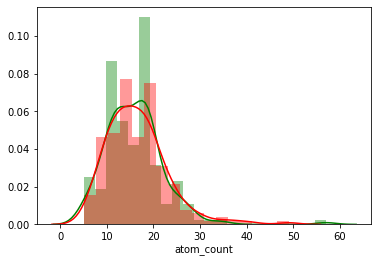

In [43]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [44]:
print(stats.ttest_ind(best_n_vals.ring_count, worst_n_vals.ring_count))

Ttest_indResult(statistic=-0.4551203186267767, pvalue=0.6492708443192239)


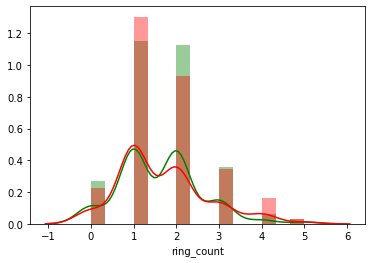

In [45]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [46]:
print(stats.ttest_ind(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

Ttest_indResult(statistic=0.8633793511766968, pvalue=0.38844891072982524)


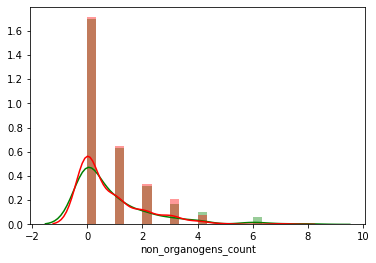

In [47]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [48]:
print(stats.ttest_ind(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=0.8530549718080837, pvalue=0.3941418969528051)


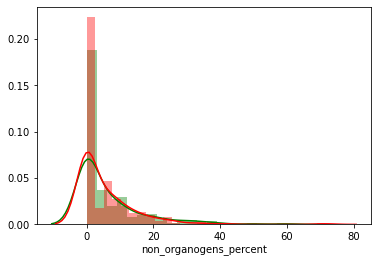

In [49]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [50]:
print(stats.ttest_ind(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

Ttest_indResult(statistic=-0.5882915574115778, pvalue=0.5566702887092347)


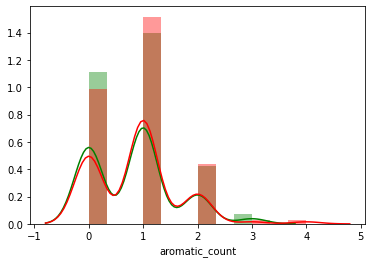

In [51]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [52]:
print(stats.ttest_ind(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

Ttest_indResult(statistic=-1.0589571328327896, pvalue=0.290261556335811)


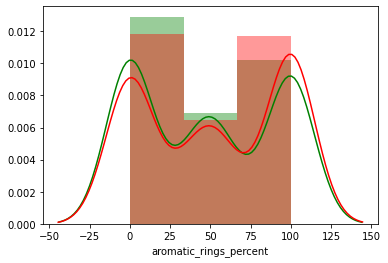

In [53]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [54]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

Ttest_indResult(statistic=1.4633664745962878, pvalue=0.14415641225731635)


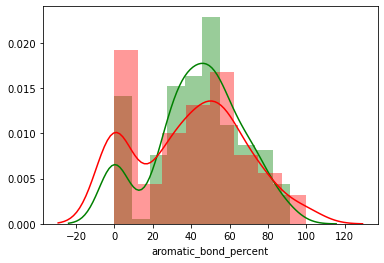

In [55]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [56]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

Ttest_indResult(statistic=-2.038004099470416, pvalue=0.04221022264610617)


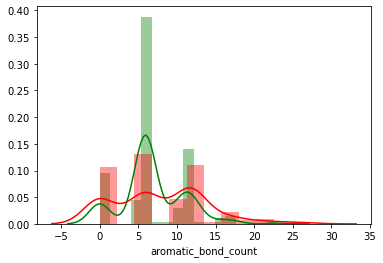

In [57]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

### Check symmetric count

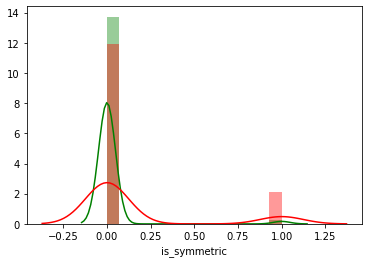

In [58]:
sns.distplot(best_n_vals.is_symmetric, color='g')
sns.distplot(worst_n_vals.is_symmetric, color='r')

### Metrics analysis among symmetric and not symmetric molecules

In [59]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [60]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in X_test_mol]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [61]:
symmetric_y_predicted = compare_data.y_predicted[symmetric_indices]

In [62]:
symmetric_y_expected = compare_data.y_expected[symmetric_indices]

In [63]:
not_symmetric_y_predicted = compare_data.y_predicted[not_symmetric_indices]

In [64]:
not_symmetric_y_expected = compare_data.y_expected[not_symmetric_indices]

In [65]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 0.6412966924631641
Test symmetric R2-score is 0.8555035248132735


In [66]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.6688050411122656
Test not symmetric R2-score is 0.8649765446029413
